In [3]:
import pypyodbc as odbc # загрузка SQL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # корректировка цены делений
import seaborn as sns



sns.set_style('darkgrid') # стиль отображения графиков. другие стили dark, white, whitegrid, darkgrid и tickers

In [4]:
# Подключение к SQL серверу
DRIVER_NAME = 'SQL SERVER'
SERVER_NAME = 'Skynet\SQLEXPRESS'
DATABASE_NAME = 'AdventureWorks2014'

connection_string = f"""
    DRIVER={{{DRIVER_NAME}}};
    SERVER={SERVER_NAME};
    DATABASE={DATABASE_NAME};
    Trust_Connection=yes;
    """
conn = odbc.connect(connection_string)
cursor = conn.cursor()
print(conn)

In [6]:
# Функция для конвертации SQL запросов в датафреймы Pandas
def create_df(request): 
    ex_request = cursor.execute(request)
    data = ex_request.fetchall()
    return pd.DataFrame(data, columns=[x[0] for x in ex_request.description])

Направим запрос на выгрузку данных из БД SQL. Основная таблица, которая будет использоваться - SalesOrderHeader. Она содержит сводную информацию о каждом заказе (номер заказа, сумма, дата заказа и пр.). Помимо этого, необходимо присоединить ещё пару таблиц, чтобы получить значение persontype, которое отражает тип заказчика.

In [7]:
sales_query = """select 
    [SalesOrderID],
    [Sales].[SalesOrderHeader].[CustomerID],
    [OrderDate],
    [SubTotal],
    [PersonType]
from [Sales].[SalesOrderHeader] 
left join [Sales].[Customer] on [Sales].[SalesOrderHeader].[CustomerID] = [Sales].[Customer].[CustomerID]
left join [Person].[Person] on [Person].[Person].[BusinessEntityID] = [Sales].[Customer].[PersonID]"""
df_sales = create_df(sales_query)
df_sales.tail(2)

,salesorderid,customerid,orderdate,subtotal,persontype
31463,75122,15868,2014-06-30,30.9700,IN
31464,75123,18759,2014-06-30,189.9700,IN


In [14]:
df_sales.isnull().sum() # Проверка значений NaN 

salesorderid    0
customerid      0
orderdate       0
subtotal        0
persontype      0
dtype: int64

In [15]:
df_sales.dtypes # Проверка типов данных

salesorderid             int64
customerid               int64
orderdate       datetime64[ns]
subtotal                object
persontype              object
dtype: object

In [8]:
df_sales['subtotal'] = df_sales.subtotal.astype('float').round(2) # преобразование суммы заказа к типу 'float'

Предварительный анализ основных описательных статистик данных

In [55]:
def highlight(df): # подсветка ячеек
    func = pd.DataFrame("", index=df_sales.describe().index, columns=df_sales.describe().columns)
    func.iloc[3:, 2] = "background-color: yellow"
    return func

df_sales.describe().style.apply(highlight, axis=None)

,salesorderid,customerid,subtotal
count,31465.000000,31465.000000,31465.000000
mean,59391.000000,20170.175687,3491.065695
std,9083.307446,6261.728960,11093.452582
min,43659.000000,11000.000000,1.370000
25%,51525.000000,14432.000000,56.970000
50%,59391.000000,19452.000000,782.990000
75%,67257.000000,25994.000000,2366.960000
max,75123.000000,30118.000000,163930.390000


Из таблицы видно, что разбор по сумме заказа очень велик, и подавляющее большинство заказов лежит очень близко к нижней границе. Исследуем эту особенность. Для этого построим графики распределения выручки и количества заказов по типам клиентов. В документации к БД можно найти расшифровку значений поля persontype: SC - магазин, IN = розничный заказчик. 

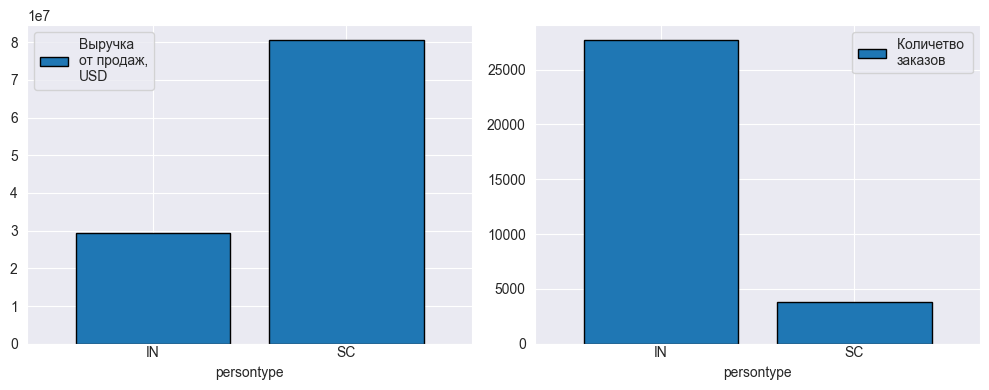

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

pivot = df_sales.groupby("persontype").agg({'subtotal': 'sum'})
pivot['subtotal'].plot(kind='bar', ec='black', ax=ax1, width=0.8)
ax1.legend(['Выручка \nот продаж,\nUSD'], loc='upper left')
ax1.set_xticks(np.arange(len(pivot.index)), pivot.index.values, rotation = 0, verticalalignment ='center')

pivot2 = df_sales.groupby("persontype").agg({'salesorderid': 'count'})
pivot2['salesorderid'].plot(kind='bar', ec='black', ax=ax2, width=0.8)
ax2.legend(['Количетво \nзаказов'])
ax2.set_xticks(np.arange(len(pivot2.index)), pivot2.index.values, rotation = 0, verticalalignment ='center')

plt.tight_layout()

Взглянем на распределения заказов по сумме и заказчиков по количеству заказов для каждой группы заказчиков

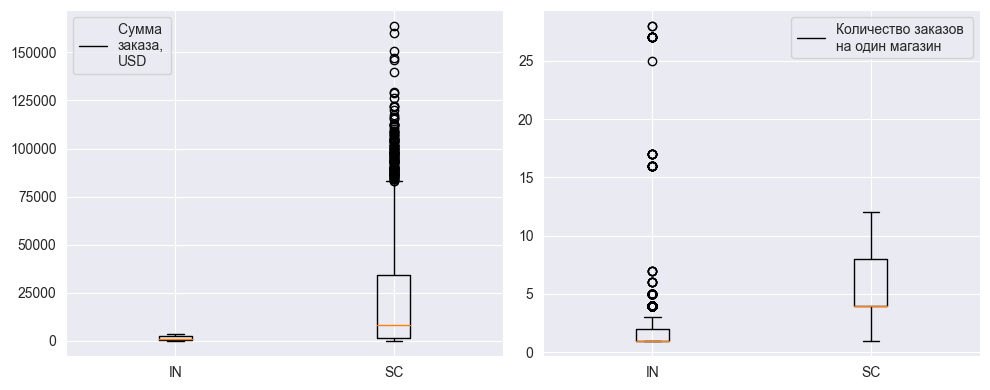

In [156]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
IN = df_sales.loc[df_sales.persontype == 'IN', 'subtotal']
SC = df_sales.loc[df_sales.persontype == 'SC', 'subtotal']
ax1.boxplot([IN, SC])
ax1.set_xticks([1, 2], ['IN', 'SC'])
ax1.legend(['Сумма \nзаказа,\nUSD'], loc='upper left')

IN2 = df_sales[df_sales.persontype == 'IN'].groupby('customerid')['salesorderid'].count()
SC2 = df_sales[df_sales.persontype == 'SC'].groupby('customerid')['salesorderid'].count()
ax2.boxplot([IN2, SC2])
ax2.set_xticks([1, 2], ['IN', 'SC'])
ax2.legend(['Количество заказов \nна один магазин'], loc='upper right')
plt.tight_layout()

In [119]:
print("Общее количество магазинов - {}".format(len(df_sales.loc[df_sales.persontype == 'SC', 'customerid'].unique())))
print("Общее розничных заказчиков - {}".format(len(df_sales.loc[df_sales.persontype == 'IN', 'customerid'].unique())))

Общее количество магазинов - 635
Общее розничных заказчиков - 18484


Посмотрим на объемы продаж по кварталам

Text(0, 0.5, 'Количество заказов')

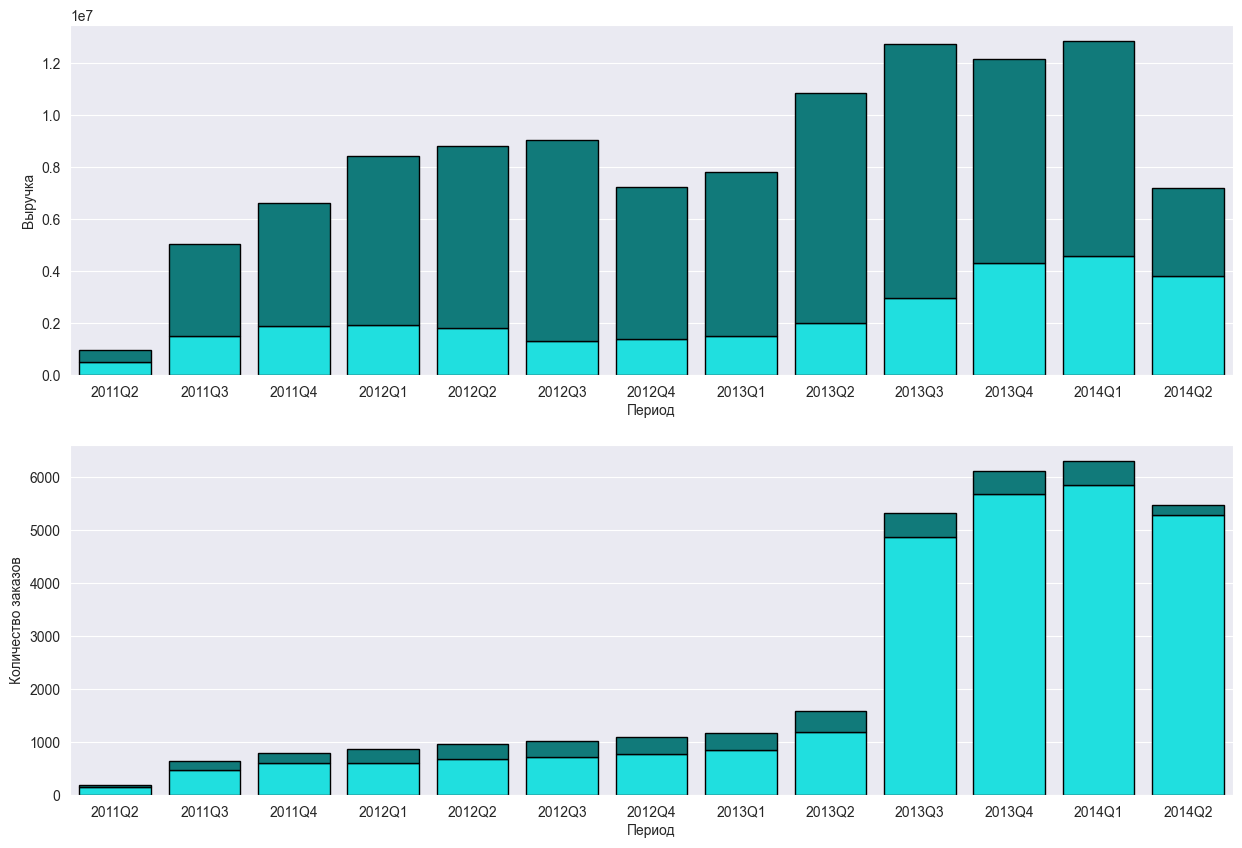

In [117]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15, 10))

sp1 = pd.DataFrame(df_sales[df_sales.persontype == 'IN'].groupby(df_sales.orderdate.dt.to_period('Q'))['subtotal'].sum())
sp2 = pd.DataFrame(df_sales[df_sales.persontype == 'SC'].groupby(df_sales.orderdate.dt.to_period('Q'))['subtotal'].sum())
sns.barplot(x=sp1.index, y=sp1.subtotal, ec='black', color='#00FFFF', label="IN", ax=ax1)
sns.barplot(x=sp1.index, y=sp2.subtotal, ec='black', color='#008B8B', label="SC", ax=ax1, bottom=sp1.subtotal)
ax1.set_xlabel("Период")
ax1.set_ylabel("Выручка")

sp3 = pd.DataFrame(df_sales[df_sales.persontype == 'IN'].groupby(df_sales.orderdate.dt.to_period('Q'))['subtotal'].count())
sp4 = pd.DataFrame(df_sales[df_sales.persontype == 'SC'].groupby(df_sales.orderdate.dt.to_period('Q'))['subtotal'].count())
sns.barplot(x=sp3.index, y=sp3.subtotal, ec='black', color='#00FFFF', label="IN", ax=ax2)
sns.barplot(x=sp3.index, y=sp4.subtotal, ec='black', color='#008B8B', label="SC", ax=ax2, bottom=sp3.subtotal)
ax2.set_xlabel("Период")
ax2.set_ylabel("Количество заказов")


Из графиков следует, что большая часть прибыли приходится на магазины. Однако подавляющее большинство заказов приходится на розничных заказчиков, которых так же на порядки больше, чем магазинов. Сравнивать эти группы между собой будет не корректно. Магазины будут сильно выбиваться вверх по всем параметрам, т.к. каждый из них по сути является агрегатором какого-то количества розничных заказчиков. В рамках текущего проекта будем анализировать розничных заказчиков. 

In [10]:
df_sales_in = df_sales[df_sales.persontype == 'IN'].reset_index(drop=True).drop('persontype', axis=1)
df_sales_in.tail(2)

,salesorderid,customerid,orderdate,subtotal
27657,75122,15868,2014-06-30,30.97
27658,75123,18759,2014-06-30,189.97


Судя по графикам продаж по кварталам, за последние 4 квартала произошел существенный рост заказов в рознице. 
Посмотрим на прирост новых заказчиков по полугодиям

In [277]:
# Формируем матрицу периодов времени
# periods = pd.DataFrame({'d1': pd.date_range(start='2011-06-30', periods=6, freq='6MS'),
#                         'd2': pd.date_range(start='2011-12-31', periods=6, freq='6MS')}, 
#                        index =['2h2011', '1h2012', '2h2012', '1h2013', '2h2013', '1h2014'])
# periods['d1'] = pd.to_datetime(periods['d1'])
# periods['d2'] = pd.to_datetime(periods['d2'])
# periods

periods = pd.DataFrame({'d1': pd.date_range(start='2011-06-30', periods=12, freq='QS'),
                        'd2': pd.date_range(start='2011-09-30', periods=12, freq='QS')}, 
                       index =['3q2011', '4q2011', '1q2012', '2q2012', '3q2012', '4q2012', 
                               '1q2013', '2q2013', '3q2013', '4q2013',
                               '1q2014', '2q2014'])
periods['d1'] = pd.to_datetime(periods['d1'])
periods['d2'] = pd.to_datetime(periods['d2'])
periods

,d1,d2
3q2011,2011-07-01,2011-10-01
4q2011,2011-10-01,2012-01-01
1q2012,2012-01-01,2012-04-01
2q2012,2012-04-01,2012-07-01
3q2012,2012-07-01,2012-10-01
4q2012,2012-10-01,2013-01-01
1q2013,2013-01-01,2013-04-01
2q2013,2013-04-01,2013-07-01
3q2013,2013-07-01,2013-10-01
4q2013,2013-10-01,2014-01-01


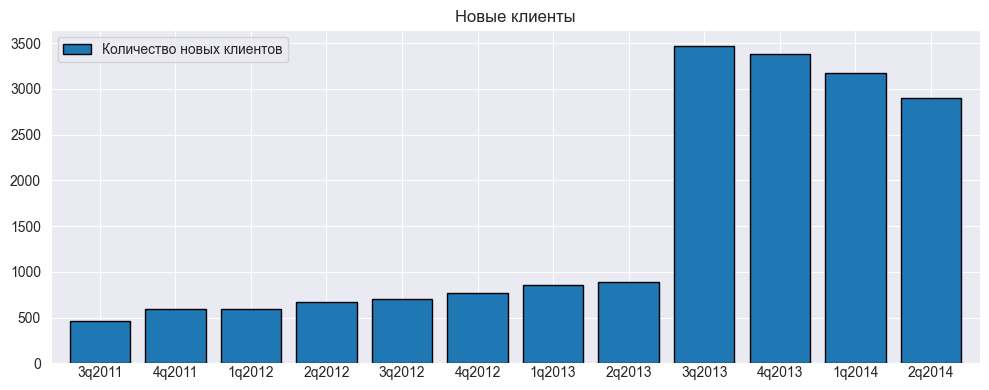

In [279]:
# Определяем новых клиентов для каждого периода и строим график
new_clients = pd.Series(dtype='float64')
current_clients = np.array([])

for index, date in periods.iterrows():
    df1 = df_sales_in[(df_sales_in.orderdate >= date['d1'] ) & (df_sales_in.orderdate < date['d2'])]
    df2 = df1[~df1.customerid.isin(current_clients)]
    new_clients = pd.concat([new_clients, pd.Series({index:len(df2.customerid.unique())})])
    current_clients = np.hstack([current_clients, df2.customerid.unique()])

ax = plt.gca()
new_clients.plot(kind='bar', figsize=(10, 4), ec='black', ax=ax, width=0.8, title='Новые клиенты')
ax.legend(['Количество новых клиентов'])
ax.set_xticks(np.arange(len(new_clients)), new_clients.index.values, rotation = 0, verticalalignment =  'center')   
plt.tight_layout()

Аналогичная ситуация с заказчиками. Это свидетельствует о том, что концу 1 полугодия 2013 года были проведены мероприятия, направленные на увеличение розничных продаж.

Перейдём непосредственно к RFM-анализу. Для этого, из запроса SQL сформируем таблицу с необходимыми данными. Аналогичную таблицу без труда можно сформировать средствами Pandas из уже имеющегося датафрейма df_sales_in. Запрос к БД применен для совершенствования навыков формирования запросов SQL.


In [47]:
rfm_query = f"""with s1 as (select 
[Sales].[SalesOrderHeader].[CustomerID], 
count([Sales].[SalesOrderHeader].[CustomerID]) frequency, 
sum([SubTotal]) monetary
from [Sales].[SalesOrderHeader]
left join [Sales].[Customer] on [Sales].[SalesOrderHeader].[CustomerID] = [Sales].[Customer].[CustomerID]
left join [Person].[Person] on [Person].[Person].[BusinessEntityID] = [Sales].[Customer].[PersonID]
where [Person].[Person].[PersonType] = 'IN'
group by [Sales].[SalesOrderHeader].[CustomerID]),

s2 as (select sub.[CustomerID] [CustomerID], max(sub.max_date) max_date, max(sub.[1_order_date]) [1_order_date]
, max(case when rn = 2 then sub.[OrderDate] end) [2_order_date]
, max(case when rn = 3 then sub.[OrderDate] end) [3_order_date]
, max(case when rn = 4 then sub.[OrderDate] end) [4_order_date]
from (select [CustomerID], [OrderDate]
, max([OrderDate]) over(partition by [CustomerID] order by [OrderDate] asc
rows between unbounded preceding and unbounded following) max_date
, first_value([OrderDate]) over (partition by [CustomerID] order by [OrderDate] asc 
rows between unbounded preceding and unbounded following) [1_order_date]
, row_number() over (partition by [CustomerID] order by [OrderDate] asc) rn
from [Sales].[SalesOrderHeader]) sub
group by [CustomerID])

select s1.[CustomerID], frequency, monetary, s2.max_date
, s2.[1_order_date] [1_order_date] 
, s2.[2_order_date] [2_order_date]
, s2.[3_order_date] [3_order_date]
, s2.[4_order_date] [4_order_date]
from s1 
left join s2 on s2.[CustomerID] = s1.[CustomerID]
--group by s1.[CustomerID]
order by monetary desc, frequency desc"""

df_rfm = create_df(rfm_query)
df_rfm['monetary'] = df_rfm.monetary.astype('float').round(2)
df_rfm.tail(2)

,customerid,frequency,monetary,max_date,1_order_date,2_order_date,3_order_date,4_order_date
18482,28094,1,2.29,2013-07-24,2013-07-24,NaT,NaT,NaT
18483,28095,1,2.29,2013-11-27,2013-11-27,NaT,NaT,NaT


Таблица включает следующие поля:


- *customerid* — ID заказчика
- *frequency* — общее количество (частота) заказов
- *monetary* — общая выручка от заказчика
- *max_date* — дата последнего заказа
- *1_order_date* — дата первого заказа
- *2_order_date* — дата второго заказа
- *3_order_date* — дата третьего заказа

Разбивку значений показателей будем проводить по трём группам: 1 - хорошо, 2 - средне, 3 - слабо.

За условную дату анализа примем 01.07.2014 г.

In [12]:
ref_date = pd.to_datetime('2014-07-01')

Первый параметр, который проанализируем — количество (частота) заказов. Оценим распределение значений данного показателя по заказчикам.

Text(0.5, 0, 'Количество заказов')

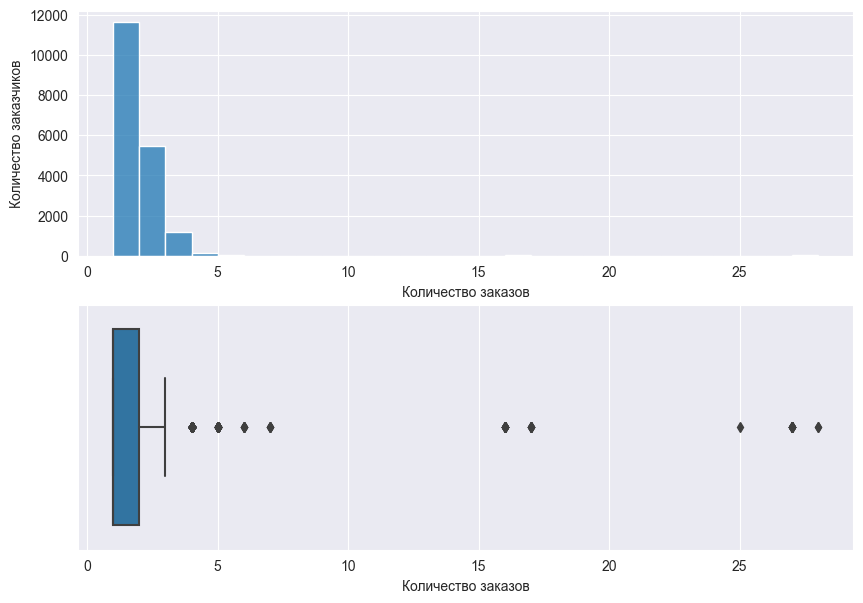

In [396]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 7))
sns.histplot(df_rfm.frequency, bins=np.arange(min(df_rfm.frequency), max(df_rfm.frequency) + 1, 1), ax=ax1)
sns.boxplot(x=df_rfm.frequency, ax=ax2)
ax1.set_xlabel("Количество заказов")
ax1.set_ylabel("Количество заказчиков")
ax2.set_xlabel("Количество заказов")

Из графиков следует, что лучшая разбивка на три группы будет следующей: 3 - 1 заказ, 2 - 2 заказа, 1 - 3 и более заказов. Создадим соответствующий столбец в таблице.

In [48]:
df_rfm['F'] = pd.cut(df_rfm.frequency, [1, 2, 3, 30], labels=[3, 2, 1], right=False)
df_rfm.tail(2)

,customerid,frequency,monetary,max_date,1_order_date,2_order_date,3_order_date,4_order_date,F
18482,28094,1,2.29,2013-07-24,2013-07-24,NaT,NaT,NaT,3
18483,28095,1,2.29,2013-11-27,2013-11-27,NaT,NaT,NaT,3


Следующий параметр, который проанализируем — давность последнего заказа (recency). Для этого прежде всего, необходимо необходимо определиться, какие заказы считать недавними, а какие наоборот. Традиционный подход предполагает проранжировать заказчиков по давности последнего заказа и разбить получившийся список на три равные группы по их количеству. Однако такой подход может оказаться не состоятельным, когда естественный период покупки сравнительно большой. Так, например, какие-то заказчики могут оказаться в более слабой группе, хотя на самом деле время следующей покупки ещё не пришло. Попробуем проанализировать время между покупками.

Посчитаем количество дней для последней покупки.

In [49]:
df_rfm['recency'] = df_rfm['max_date'].apply(lambda x: (ref_date - x).days)

Определим интервал между первой-второй, второй-третьей и третьей-четвертой покупками клиентов.

In [50]:
df_rfm['period_12'] = (df_rfm['2_order_date'] - df_rfm['1_order_date']).dt.days
df_rfm['period_23'] = (df_rfm['3_order_date'] - df_rfm['2_order_date']).dt.days
df_rfm['period_34'] = (df_rfm['4_order_date'] - df_rfm['3_order_date']).dt.days
df_rfm.tail(2)

,customerid,frequency,monetary,max_date,1_order_date,2_order_date,3_order_date,4_order_date,F,recency,period_12,period_23,period_34
18482,28094,1,2.29,2013-07-24,2013-07-24,NaT,NaT,NaT,3,342,NaN,NaN,NaN
18483,28095,1,2.29,2013-11-27,2013-11-27,NaT,NaT,NaT,3,216,NaN,NaN,NaN


Построим графики распределения значений давности последних заказов и графики распределения периодов между заказами.

[Text(0.5, 1.0, 'Период между вторым и третьим заказами'), Text(0, 0.5, 'Дни')]

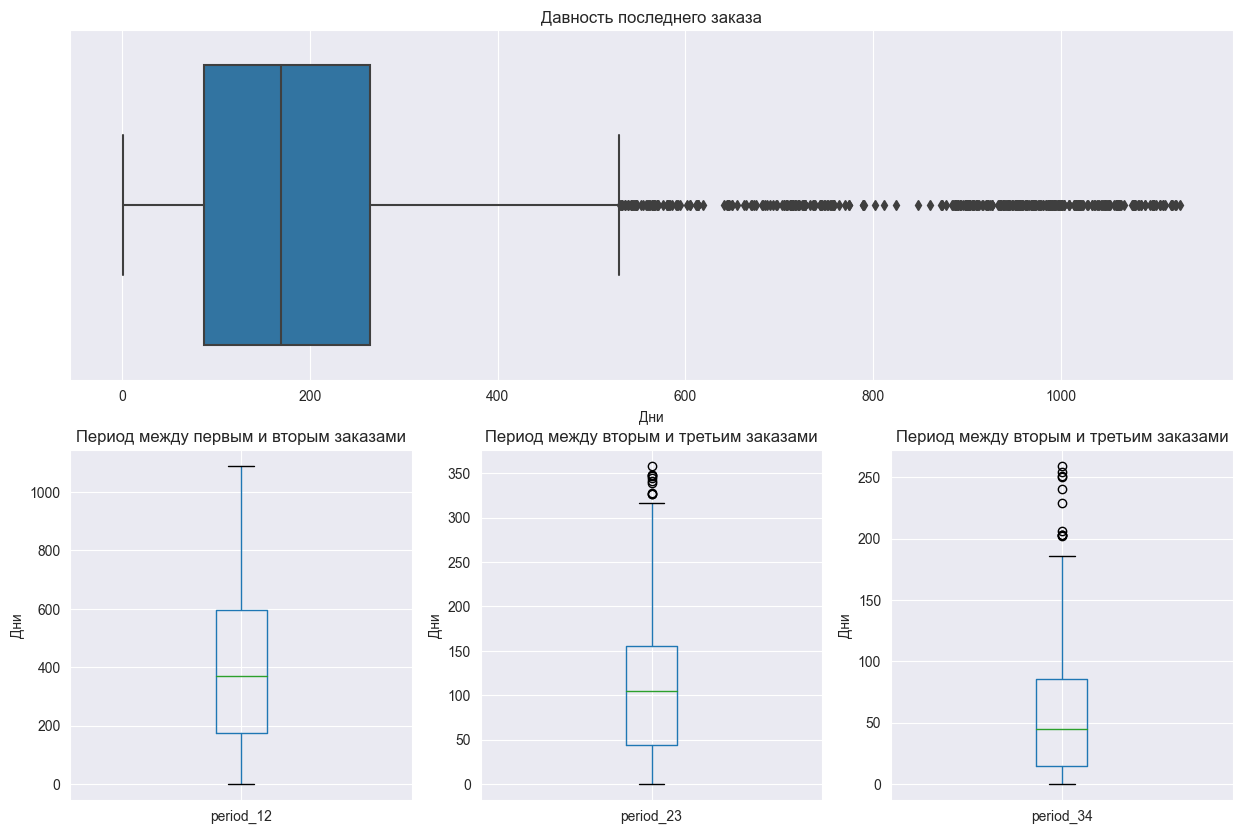

In [51]:
fig, axes = plt.subplot_mosaic("AAA;BCD", figsize=(15,10))

sns.boxplot(x=df_rfm.recency, ax=axes['A'])
axes['A'].set(title='Давность последнего заказа', xlabel='Дни')

df_rfm.boxplot(column='period_12', ax=axes['B'])
axes['B'].set(title='Период между первым и вторым заказами', ylabel='Дни')
df_rfm.boxplot(column='period_23', ax=axes['C'])
axes['C'].set(title='Период между вторым и третьим заказами', ylabel='Дни')
df_rfm.boxplot(column='period_34', ax=axes['D'])
axes['D'].set(title='Период между вторым и третьим заказами', ylabel='Дни')

Медианое значение давности последнего заказа среди всех значений лежит в районе 180 дней, в то время, как большинство клиентов, совершивших вторую покупку, сделали её спустя 180 и более дней после первой. Примечательно, что последующие покупки клиенты совершают всреднем быстрее, чем предыдущие. Используем это обстоятельство для определения ранга давности последнего заказа. Таким образом, ранг будет зависеть не только от давности, но и от того, какая по счету покупка была послеждней.

In [58]:
r121b = df_rfm.period_12.quantile(.3333)
r122b = df_rfm.period_12.quantile(.6666)
r231b = df_rfm.period_23.quantile(.3333)
r232b = df_rfm.period_23.quantile(.6666)
r341b = df_rfm.period_34.quantile(.3333)
r342b = df_rfm.period_34.quantile(.6666)

In [59]:
df_rfm.loc[df_rfm.frequency == 1, 'R'] = pd.cut(df_rfm.recency, [0, r121b, r122b, 1200], labels=[1, 2, 3], right=False)
df_rfm.loc[df_rfm.frequency == 2, 'R'] = pd.cut(df_rfm.recency, [0, r231b, r232b, 1200], labels=[1, 2, 3], right=False)
df_rfm.loc[df_rfm.frequency > 2, 'R'] = pd.cut(df_rfm.recency, [0, r341b, r342b, 1200], labels=[1, 2, 3], right=False)
df_rfm = df_rfm.reindex(['customerid', 'recency', 'frequency', 'monetary', 'R', 'F'], axis=1)
df_rfm.head(2)

,customerid,recency,frequency,monetary,R,F
0,12301,70,5,13295.38,3,1
1,12132,104,5,13294.27,3,1


Последний показатель, который проанализируем - выручка (monetary). Отличительной особенностью выручки является тот факт, что к ней обычно применим закон Парето, который позволяет выделить наиболее прибыльных клиентов, которых обычно меньшенство. Границы групп определим по методу касательных, который обычно применяется при ABC-анализе. Для этого:  
-построим кумулятивную кривую выручки по клиентам в порядке убывания приносимой ими выручки  
-проведём прямую линию от начала до конца кумулятивной кривой  
-поднимем получившуюся прямую до точки касания с изгибом кривой.  
Получившаяся точка разграничит заказчиков на группу 1 и 2,3. Для разграничения групп 2,3 проделаем аналогичную процедуру. 

In [64]:
df_rfm['cum'] = df_rfm.loc[:, 'monetary'].cumsum()[::-1]
df_rfm.tail(2)

,customerid,recency,frequency,monetary,R,F,M,RFM_score,cum
18482,28094,342,1,2.29,2,3,3,233,2.935868e+07
18483,28095,216,1,2.29,1,3,3,133,2.935868e+07


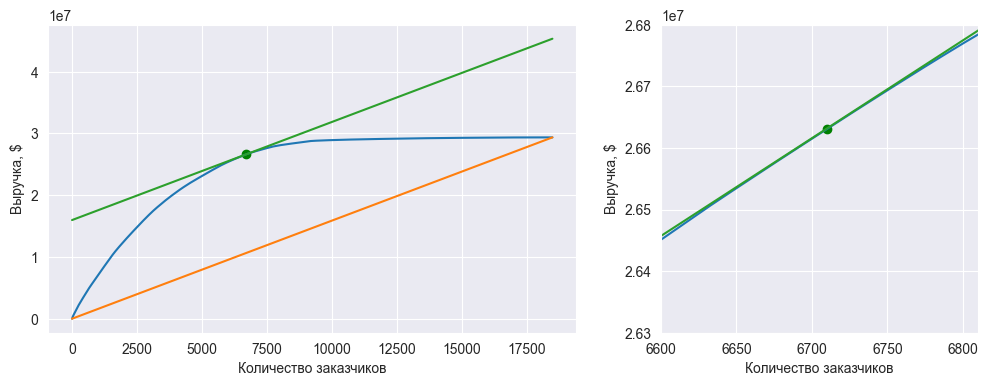

In [350]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [2, 1.2]})

ax2.set_xlim(6600, 6810)
ax2.set_ylim(0.263e+08, 0.268e+08)

a = df_rfm.loc[0, 'cum']
b = df_rfm.loc[18483, 'cum']
c = 0.15965e+08

for ax in [ax1, ax2]:
    ax.set(xlabel='Количество заказчиков', ylabel='Выручка, $')
    ax.plot(df_rfm.index, df_rfm.cum)   
    ax.plot([0, 18483], [a, b])
    ax.plot([0, 18483], [a+c, b+c])
    ax.scatter(6710, df_rfm.loc[6710, 'cum'], color='g', alpha = 1)

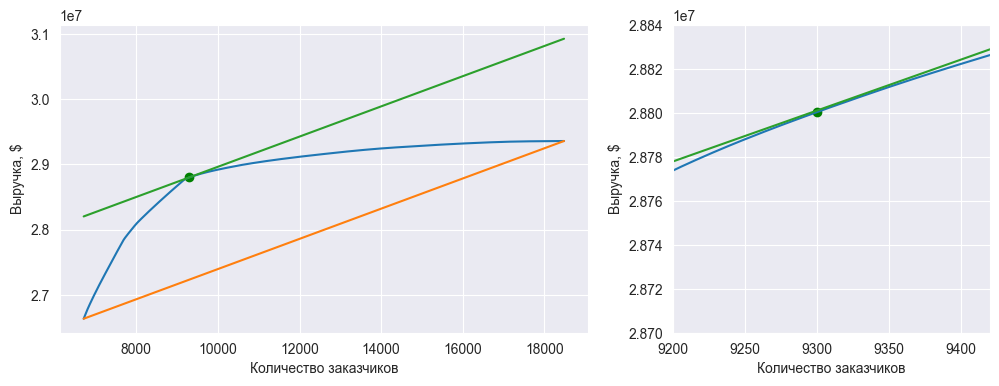

In [351]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [2, 1.2]})

ax2.set_xlim(9200, 9420)
ax2.set_ylim(0.287e+08, 0.2884e+08)

a = df_rfm.loc[6710, 'cum']
b = df_rfm.loc[18483, 'cum']
c = 0.0157e+08

for ax in [ax1, ax2]:
    ax.set(xlabel='Количество заказчиков', ylabel='Выручка, $')
    ax.plot(df_rfm[df_rfm.index >= 6710].index, df_rfm[df_rfm.index >= 6710].cum)   
    ax.plot([6710, 18483], [a, b])
    ax.plot([6710, 18483], [a+c, b+c])
    ax.scatter(9300, df_rfm.loc[9300, 'cum'], color='g', alpha = 1)

In [65]:
df_rfm['M'] = pd.cut(df_rfm.index, [0, 6710, 9300, 18484], labels=[1, 2, 3], right=False)

def RFM_score(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

df_rfm['RFM_score'] = df_rfm.apply(RFM_score,axis=1)
df_rfm.drop('cum', inplace=True, axis=1)
df_rfm.tail(2)

,customerid,recency,frequency,monetary,R,F,M,RFM_score
18482,28094,342,1,2.29,2,3,3,233
18483,28095,216,1,2.29,1,3,3,133


Заказчики распределены по RFM-сегментам. Построим гистограммы для получившихся сегментов по количеству клиентов и выручке.

<AxesSubplot:xlabel='RFM_score', ylabel='monetary'>

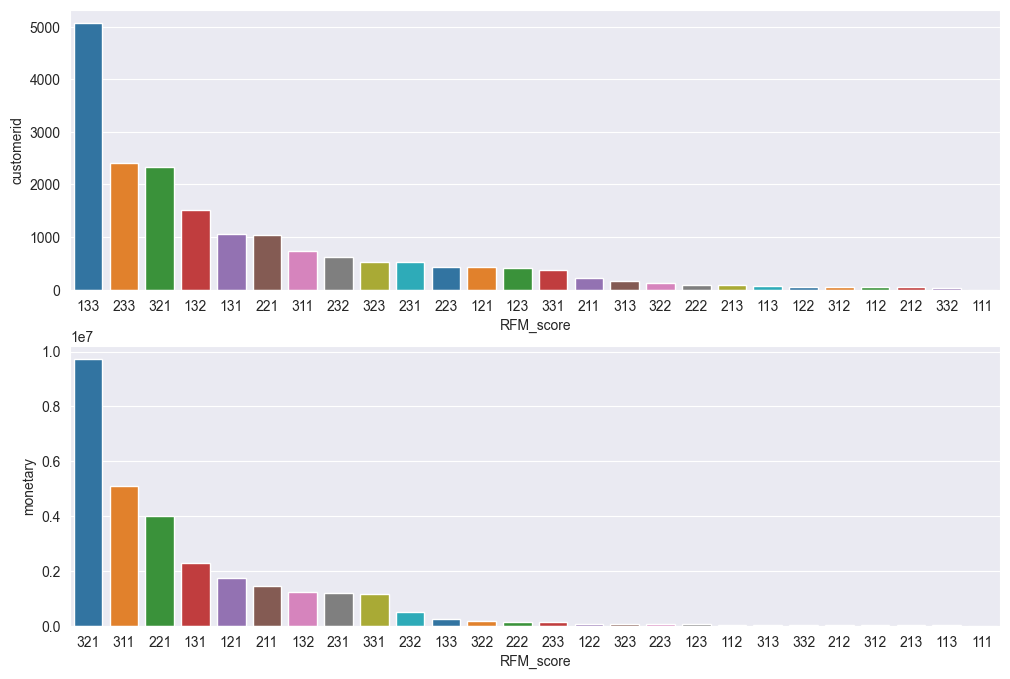

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

sg1 = df_rfm.groupby('RFM_score')['customerid'].count().sort_values(ascending=False).reset_index()
sns.barplot(data=sg1, x='RFM_score', y='customerid', palette=sns.color_palette("tab10"), ax=ax1)

sg2 = df_rfm.groupby('RFM_score')['monetary'].sum().sort_values(ascending=False).reset_index()
sns.barplot(data=sg2, x='RFM_score', y='monetary', palette=sns.color_palette("tab10"), ax=ax2)

# Выводы и результаты: 

Проведена классификация клиентов по показателям: давность последней покупки, частота покупок и выручка от продаж.
В дальнейшем, данные могут быть обогащены и использованы для формирования списков и распределения по маркетинговым мероприятиям или для более детального анализа.


Больше всего заказчиков с низкой суммой заказов и одной покупкой (133, 233). Прибыль от них не значительная. Скорее всего, это покупатели аксесуаров, недорогого навесного оборудования, одежды и запчастей.

К концу 1 полугодия 2013 года были проведены мероприятия, направленные на увеличение розничных продаж и заказчиков. Выручка тоже возросла, однако не соразмерно с количеством продаж и заказчиков, что согласуется с п.1. Возможно, стоит поработать с продвижением основного продукта - велосипедов в сборе.

Самая прибыльная и следующая по многочисленности после 133 и 233 группа - 321. За ней по прибыльности идёт 311. Клиенты из этих двух групп уже давно ничего не покупали и могут быть потеряны. На них необходимо направить основные усилия. 
